## Equations for Moment Closure of Network-based micro-model for divestment of bounded rational households.

Imports and setup

In [18]:
%matplotlib notebook

#import numpy as np
import sympy as s
import pickle as pkl
from sympy.abc import epsilon, phi, tau
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
s.init_printing()
import numpy as np
import matplotlib.pyplot as plt
from assimulo.solvers import IDA
from assimulo.problem import Implicit_Problem
from scipy.optimize import root

Define variables and parameters for the economic subsystem:

In [19]:
# Total labor and labor shares in sectors
L, Lc, Ld = s.symbols('L L_c L_d', positive=True, real=True)
# Total capital in sectors
Kc, Kd = s.symbols('K_c K_d', positive=True, real=True)
# Equilibrium wage and capital return rates in sectors
w, rc, rd = s.symbols('w r_c r_d', positive=True, real=True)
# Resource usage rage, resource stock, knowledge Stock
R, G, C = s.symbols('R, G, C', positive=True, real=True)
# savings rate, capital depreciaten rate, and elasticities of labor, capital and knowledge
rs, delta, pi, kappac, kappad, xi, mu = s.symbols('s delta pi kappa_c, kappa_d xi, mu', positive=True, real=True, integer=True)
# solow residuals of clean and dirty sector, prefactor for resource cost, energy efficiency, initial resource stock
bc, bd, bR, e, G0 = s.symbols('b_c b_d b_R e G_0', positive=True, real=True)
# substitutions for resolution on constraints from market clearing.
Xc, Xd, XR = s.symbols('X_c X_d X_R', positive=True, real=True)
# and their time derivatives.
dXc, dXd, dXR = s.symbols('\dot{X}_c \dot{X}_d \dot{X}_R', real=True)
# fraction of savings going into clean sector
n = s.symbols('n', positive=True, real=True)
# time derivatives
dKc, dKd, dC, dG = s.symbols('\dot{K}_c \dot{K}_d \dot{C} \dot{G}')
# implicit condition for n
F = s.symbols('F')
zero = s.symbols('zo')

**Treatment the equations describing economic production and capital accumulation**

Substitutute solutions to algebraic constraints of economic system (market clearing for labor and expressions for capital rent and resource flow)

In [20]:
# These are double checked
subs2 = {w: pi * L**(pi-1.) * (Xc + Xd*XR)**(1.-pi),
        rc: kappac/Kc*Xc*L**pi*(Xc + Xd*XR)**(-pi),
        rd: kappad/Kd*Xd*XR*L**pi*(Xc + Xd*XR)**(-pi),
        R:  bd/e*Kd**kappad*L**pi*(Xd*XR/(Xc + Xd*XR))**pi,
        Lc: L*Xc/(Xc + Xd*XR),
        Ld: L*Xd*XR/(Xc + Xd*XR)}

In [21]:
# These are double checked
subs3 = {Xc: (bc*Kc**kappac * C**xi)**(1./(1.-pi)),
         Xd: (bd*Kd**kappad)**(1./(1.-pi)),
         XR: (1.-bR/e*(G0/G)**mu)**(1./(1.-pi))}
# Those too
subs4 = {dXc: (1./(1.-pi))*(bc*Kc**kappac * C**xi)**(pi/(1.-pi))*bc*(kappac*Kc**(kappac-1)*dKc*C**xi + Kc**kappac*xi*C**(xi-1)*dC),
         dXd: (1./(1.-pi))*(bd*Kd**kappad)**(pi/(1.-pi))*bd*kappad*Kd**(kappad-1)*dKd,
         dXR: (1./(1.-pi))*(1.-bR/e*(G0/G)**mu)**(pi/(1.-pi))*(mu*bR/e*(G0**mu/G**(mu+1))*dG)}

Dynamic equations for the economic variables depending on n, the fraction of savings going into the clean sector

In [23]:
subs5 = {dKc: n*rs*(rc*Kc + rd*Kd + w*L) - delta*Kc,
         dKd: - delta*Kd + (1-n)*rs*(rc*Kc + rd*Kd + w*L),
         dC: bc*Lc**pi*Kc**kappac * C**xi - delta*C,
         dG: -R}

We want returns to capital to be equal in the clean and the dirty sector. This means, that for the initial conditions the returns and their derivatives with respect to time have to be equal. Then, for the integration, it is suficient to keep the condition for the time derivatives of the returns. 
This defines implicit condition for n, the fraction of savings invested in the clean sector.

In [24]:
raw_rdiff = (rc - rd).subs(subs2)
rdiff = raw_rdiff.subs(subs3)
raw_drdiff = L**pi*(-pi)*(Xc + Xd*XR)**(-pi-1)*(dXc + dXd*XR+ Xd*dXR)*(kappac/Kc*Xc - kappad/Kd*Xd*XR) + L**pi*(Xc + Xd*XR)**(-pi)*(kappac*(dXc*Kc - Xc*dKc)/(Kc**2.) - kappad*((dXd*XR + Xd*dXR)*Kd - Xd*XR*dKd)/(Kd**2.))
drdiff = raw_drdiff.subs(subs4).subs(subs5).subs(subs2).subs(subs3)

To double check: the difference of capital returns:

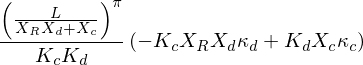

In [25]:
s.simplify(raw_rdiff)

And the time derivative of the difference of capital returns

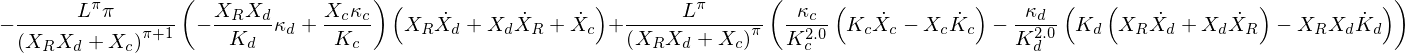

In [26]:
raw_drdiff

List of dynamic variables and the right hand side of their dynamic equations as well as a list of indicators of whether these equations are explicit of implicit

In [27]:
var_symbols = [Kc, Kd, G, C, n]

rhs_1 = s.Matrix([dKc, dKd, dG, dC, drdiff]).subs(subs5).subs(subs2).subs(subs3)
rhs_2 = s.Matrix([dKc, dKd, dG, dC, n - 1]).subs(subs5).subs(subs2).subs(subs3)

eq_implicit = [False, False, False, False, True]

Values for parameters

In [28]:
param_symbols = [bc, bd, bR, e, rs, delta, pi, kappac, kappad, xi, mu, G0, L]
param_values = [1., 1.5, 1., 5., 0.25, 0.06, 0.5, 0.5-1./8., 0.5, 1./8., 1., 3000., 100.]
subs_params = {symbol: value for symbol, value in zip(param_symbols, param_values)}

rhs_1 = rhs_1.subs(subs_params)
rhs_2 = rhs_2.subs(subs_params)
rdiff = rdiff.subs(subs_params)
drdiff = drdiff.subs(subs_params)

In [31]:
dependent_vars = {'w': w, 'rc': rc, 'rd': rd, 'R': R, 'Lc': Lc, 'Ld': Ld}
for key in dependent_vars.keys():
    dependent_vars[key] = dependent_vars[key].subs(subs2).subs(subs3).subs(subs_params)
dependent_vars

{'Lc': 100.0*C**0.25*K_c**0.75/(1.0*C**0.25*K_c**0.75 + 2.25*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0),
 'Ld': 225.0*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0/(1.0*C**0.25*K_c**0.75 + 2.25*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0),
 'R': 4.5*K_d**1.0*((-600.0*G**(-1.0) + 1.0)**2.0/(1.0*C**0.25*K_c**0.75 + 2.25*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0))**0.5,
 'rc': 3.75*C**0.25*K_c**(-0.25)*(1.0*C**0.25*K_c**0.75 + 2.25*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0)**(-0.5),
 'rd': 11.25*(-600.0*G**(-1.0) + 1.0)**2.0*(1.0*C**0.25*K_c**0.75 + 2.25*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0)**(-0.5),
 'w': 0.05*(1.0*C**0.25*K_c**0.75 + 2.25*K_d**1.0*(-600.0*G**(-1.0) + 1.0)**2.0)**0.5}

In [11]:
s.simplify(drdiff.subs({var: val for var, val in zip([Kc, Kd, C, G], [1, 1, 1, 1])}))

In [12]:
def prep_rhs(t, Y, Yd, sw):
    
    var_symbols = [Kc, Kd, G, C, n]
    sbs = {var: val for (var, val) in zip(var_symbols, Y)}
    if sw[0] or sw[2]:
        rval = rhs_1.subs(sbs)
    else:
        rval = rhs_2.subs(sbs)
        
    for i in [0, 1, 2, 3]:
        rval[i] = Yd[i] - s.simplify(rval[i])
    rval = np.array([float(x) for x in rval.evalf()])
    print(t)
    return rval

def state_events(t, Y, Yd, sw):
    
    var_symbols = [Kc, Kd, G, C, n]
    sbs = {var: val for (var, val) in zip(var_symbols, Y)}
    
    event_1 = Y[-1]-1
    event_2 = Y[0]#float(rdiff.subs(sbs).evalf())
    
    # print('events', event_1, event_2, sw)
    return np.array([event_1, event_2, 0])

def handle_event(solver, event_info):
    if event_info[0] != 0:
        solver.sw[0] = False
        solver.sw[1] = True
        subs_ini = {symbol: value for symbol, value in zip(var_symbols, solver.y)}
        solver.yd = np.array([float(x) for x in list(rhs_2.subs(subs_ini).evalf())])
        print('first event, n reaching 1')
        print(solver.y)
        print(solver.yd)
        solver.re_init(solver.t, solver.y, solver.yd, sw0=solver.sw)
    elif event_info[1] != 0:
        solver.sw[1] = False
        solver.sw[2] = True
    pass



Define sane initial conditions, that solve the residue function (as Frank called it).
This means in my case, that rc-rd as well as d/dt (rc-rd) have to be zero.

[-6.54919113499288e-16, 0]
{K_c: 1.0, K_d: 1000.0, G: 3000.0, C: 13.58954495999982, n: 0.0010578910268909604}
0.189610294854420 0.189610294854421


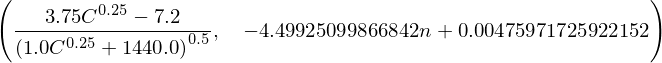

In [13]:
# define initial values for Kc, Kd, C and G
Y0 = [1., 1000., 3000.]
sym = [Kc, Kd, G]
subs_ini = {symbol: value for symbol, value in zip(sym, Y0)}

sbi0 = subs_ini.copy()

F_ini_1 = s.simplify(rdiff.subs(subs_ini))
fun1 = lambda x: F_ini_1.subs({C: x}).evalf()
r1 = root(fun1, 1)
subs_ini[C] = r1.x[0]

sbi1 = subs_ini.copy()

F_ini_2 = s.simplify(drdiff.subs(subs_ini))
fun2 = lambda x: F_ini_2.subs({n: x}).evalf()
r2 = root(fun2, .5)
subs_ini[n] = r2.x[0]

sbi2 = subs_ini.copy()

Y0 = np.array([subs_ini[var] for var in var_symbols])
Yd0 = np.array(list(rhs_1.subs(subs_ini)))
t0 = 0
sw0 = [True, False, False]
print([rdiff.subs(subs_ini), drdiff.subs(subs_ini)])
print(subs_ini)
print(rc.subs(subs2).subs(subs3).subs(subs_params).subs(subs_ini), rd.subs(subs2).subs(subs3).subs(subs_params).subs(subs_ini))
s.simplify(rdiff.subs(sbi0)), s.simplify(drdiff.subs(sbi1))

Define the problem for assimulo and run the simulation

In [14]:
mod = Implicit_Problem(prep_rhs, Y0, Yd0, t0, sw0=sw0)
mod.algvar = eq_implicit
mod.state_events = state_events
mod.handle_event = handle_event
sim = IDA(mod)
sim.rtol = 1.e-8        #Sets the relative tolerance
sim.atol = 1.e-6        #Sets the absolute tolerance
t, Y, Yd = sim.simulate(40)

2.53535117118494e-07
2.53535117118494e-07
2.53535117118494e-07
2.53535117118494e-07
2.53535117118494e-07
2.53535117118494e-07
[IDA Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
5.07070234236988e-07
1.014140468473976e-06
2.028280936947952e-06
2.028280936947952e-06
2.028280936947952e-06
2.028280936947952e-06
2.028280936947952e-06
2.028280936947952e-06
4.056561873895904e-06
4.056561873895904e-06
4.056561873895904e-06
4.056561873895904e-06
4.056561873895904e-06
4.056561873895904e-06
8.113123747791807e-06
8.113123747791807e-06
8.113123747791807e-06
8.113123747791807e-06
8.113123747791807e-06
8.113123747791807e-06
1.6226247495583615e-05
1.6226247495583615e-05
1.6226247495583615e-05
1.6226247495583615e-05
1.6226247495583615e-05
1.6226247495583615e-05
3.245249499116723e-05
3.245249499116723e-05
3.245249499116723e-05
3.245249499116723e-05
3.245249499116723e-05
3.245249499116723e-05
6.490498998233446e-05
6.4904

Plot the results

<IPython.core.display.Javascript object>


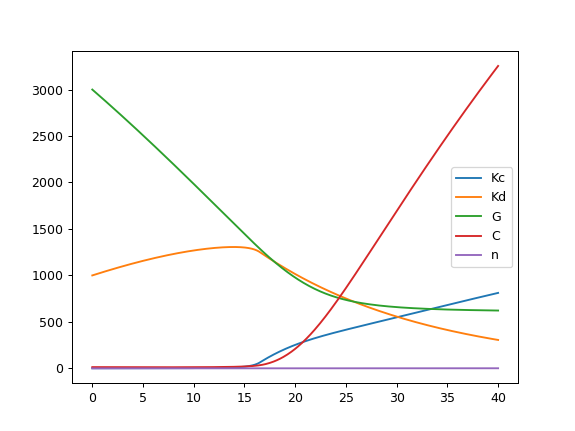

In [15]:
fig, axes = plt.subplots()
for i, lab in enumerate(['Kc', 'Kd', 'G', 'C', 'n']):
    axes.plot(t,Y[:,i],label=lab)
plt.legend()

<IPython.core.display.Javascript object>


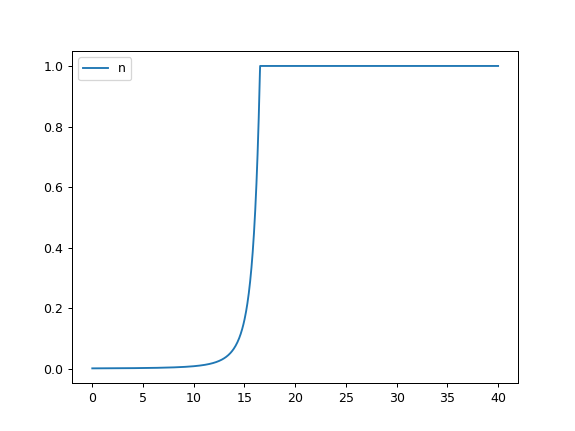

In [16]:
fig, axes = plt.subplots()
i = 0
axes.plot(t[i:],Y[i:,4],label='n')
plt.legend()

So, apparently, the representative agent is unable to satisfy the optimality condition if n is between zero and one and solves this problem by sneakily reallocating capital from the dirty to the clean sector. This is bad behavior. I command it not to do this! Therefore, I will have to define the problem in pieces.

<IPython.core.display.Javascript object>


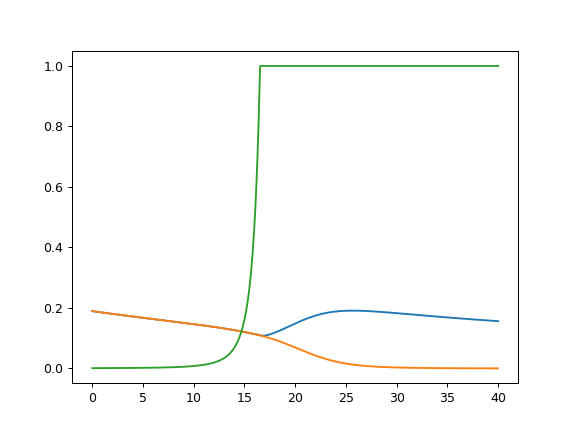

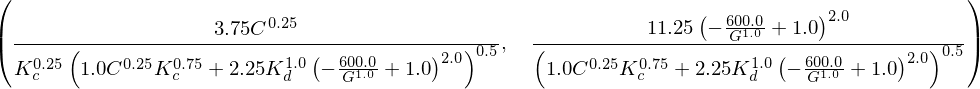

In [17]:
N = len(t)
rvalues = np.zeros((N,3))
rceq = rc.subs(subs2).subs(subs3).subs(subs_params)
rdeq = rd.subs(subs2).subs(subs3).subs(subs_params)

for i in range(N):
    sbs = {var: val for (var, val) in zip(var_symbols, Y[i,:])}
    rvalues[i,:] = (rceq.subs(sbs).evalf(), rdeq.subs(sbs).evalf(), Y[i,4])

fig, ax = plt.subplots()
ax.plot(t, rvalues)

rceq, rdeq